# Image Classification with PyTorch

One of my favourite animals is a sloth, because of its shy and chill personality. 

We're going to use computer vision to tackle a timeless internet question: is it a sloth or a pain au chocolat? This task is a binary image classification problem.

![sloth_or_pain_au_chocolat.jpg](sloth_or_pain_au_chocolat.jpg)

In the era of deep learning, data scientists and machine learning engineers rarely build and train neural networks entirely from scratch. However, a significant part of any machine learning project involves collecting, preparing, and loading data for the model. While we will be fine-tuning a pre-trained model, that won't be the primary focus of our training.

## References 
In this session, we'll adapt code from PyTorch.org's [tutorials](https://pytorch.org/tutorials), particularly from their guide on [loading custom datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html), to load our collected dataset into PyTorch.

After that, we'll use guidance from this [transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning) tutorial to conduct an image classification task using a pre-trained model that we will fine-tune.



## Package Imports

Like all great Python projects, we will start with some package imports! 

This project uses the following: 
- `NumPy` for manipulating numerical arrays
- `Matplotlib.pyplot` for plotting
- `time`, which provides time-related functions
- `os`, a way of providing functionality that interacts with the operating system
- `copy`, for copying objects
- various packages from torch, including:
    - `torch`
    - `torch.nn`, which contains the basic building blocks for neural networks
    - `torch.optim`, a package containing various optimization algorithms for PyTorch
    - `lr_scheduler` from `torch.optim`, for adjusting the learning rate based on the number of epochs
    - `torch.backends.cudnn` as `cudnn`, a means for PyTorch to talk to the GPU (although GPUs may not be supported in your workspace)
- `torchvision`, which provides additional functionalities to manipulate and process images, including
    - `datasets`, which contains built in datasets
    - `models`, containing models for various tasks, including image processing
    - `transforms`, which we'll use to transform images in preparation for image processing

Do the necessary installation using `pip install PACKAGE_NAME` for the abovementioned packages.


In [1]:
# Package imports go here
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

### Initalizations
For fast runtime, let's begin our project by setting `cudnn.benchmark` to True. 

`torch.backends.cudnn.benchmark` enables a benchmarking mode in cuDNN. When set to True, it allows cuDNN to find the most efficient algorithms for the current network configuration, which can improve runtime performance when input sizes remain consistent across iterations. However, if input sizes vary between iterations, enabling this can result in repeated benchmarking, potentially reducing performance.


You can read more about this [here](https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936).

In [9]:
# Enable cudnn benchmark
cudnn.benchmark = True

## Reading and transforming the data

While [the PyTorch.org](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) tutorial provides extensive information on loading, transforming, rescaling, cropping, and converting images to tensors using `torch` and `torch.utils`, we'll be using the `torchvision` package, which provides some frequently used data loaders and transforms out-of-the-box.

One of the things it assumes is that data is organized in a certain way. Navigate to the data folder to see how the data is structured. Within the directory called "data/sloths_versus_pain_au_chocolat", there are two folders called `"train"` and `"val"`. Our dataset contains two labels:
- `sloth`, and
- `pain_au_chocolat`
so our folders are named and organized accordingly. Note that the images contained in the `sloth`, and `pain_au_chocolat` folders don't need to be named in any way, as long as the folders themselves are labelled correctly.

To adapt this tutorial to use different data, all you need to do is change the names of the `sloth`, and `pain_au_chocolat` folders, and upload different images into them.    

When running code in notebooks, sometimes a file called `.ipynb_checkpoints` can show up in our training and validation folders. We'll remove these with the lines below.

In [3]:
%rm -R data/sloths_versus_pain_au_chocolat/train/.ipynb_checkpoints
%rm -R data/sloths_versus_pain_au_chocolat/val/.ipynb_checkpoints

# To make sure that the deletion has occurred
%ls data/sloths_versus_pain_au_chocolat/train/ -a   

rm: data/sloths_versus_pain_au_chocolat/train/.ipynb_checkpoints: No such file or directory
rm: data/sloths_versus_pain_au_chocolat/val/.ipynb_checkpoints: No such file or directory
ls: -a: No such file or directory
data/sloths_versus_pain_au_chocolat/train/:
pain_au_chocolat/ sloths/


We'll begin loading and transforming our data by defining the specific transforms we'd like to use from `torchvision`.

The specific transforms we'll use on our training set are:

* These introduce randomness and variation to the images, acting as a form of data augmentation. This simulates different viewing conditions, helps prevent overfitting, and improves the robustness of the model.
   * `RandomResizedCrop()`, used to crop a random portion of an image and resize it to a given size, passed as the first argument to the function
   * `RandomHorizontalFlip()`, used to horizontally flip an image randomly with a given probability (default is 0.5)
* Standard transformations to convert image data into a format suitable for model training and ensure pixel values are normalized for better model convergence.
   * `ToTensor()`, used to convert an image or `numpy.ndarray` to a tensor
   * `Normalize()`, used to normalize a tensor image with given means and standard deviations, passed as lists as the first and second arguments, respectively (taking tensors as input). If the images are similar to ImageNet images, we can use the mean and standard deviation of the ImageNet dataset. These are - `mean` = [0.485, 0.456, 0.406] and `std` = [0.229, 0.224, 0.225].

The specific transforms we'll use on our validation set are:

* These ensure that the images are scaled to a uniform size and cropped centrally to maintain consistency across samples. 
   * `Resize()` used to resize an input to a given size, passed as the first argument
   * `CenterCrop()` to crop a given image at the center, based on dimensions provided in the first argument
* Similar to the training set, these standard transformations are applied to convert images into tensors and normalize pixel values, ensuring compatibility with the trained model.
   * `ToTensor()`
   * `Normalize()`

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Next, we'll:
- create a data directory path containing our dataset
- pass our directory to `datasets.ImageFolder()` to create a data loader called `image_datasets`, where the images are arranged in the same way our folders are currently structured
- use `image_datasets` to obtain our training and validation `dataset_sizes` and `class_names`
- pass `image_datasets` to `torch.utils.data.DataLoader()`, which enables us to sample from our dataset, using
    - `batch_size` = 4, which uses 4 images per batch
    - `shuffle` = True, which will shuffle the data at every epoch


In [5]:
# Provide data directory
data_dir = 'data/sloths_versus_pain_au_chocolat'

# Create image folders for our training and validation data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Obtain dataset sizes from image_datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Obtain class_names from image_datasets
class_names = image_datasets['train'].classes

# Use image_datasets to sample from the dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True)
               for x in ['train', 'val']}

In [6]:
# Change selected device to CUDA, a parallel processing platform, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualizing Examples From Our Dataset 

### Visualization function



In [7]:
def imshow(inp, title=None):
    # The transpose is required to get the images into the correct shape
    inp = inp.numpy().transpose((1, 2, 0))

    # Using default values for mean and std but can customize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # To visualize the correct colors
    inp = std * inp + mean

    # To view a clipped version of an image
    inp = np.clip(inp, 0, 1)

    # Visualize inp
    plt.imshow(inp)

    if title is not None:  # Plot title goes here
        plt.title(title)
    # Enables the function to pause while the plots are updated
    plt.pause(0.001)

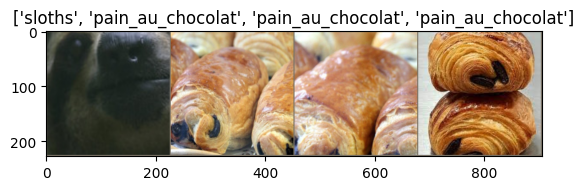

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the grid with a title that concatenates all the class labels
imshow(out, title=[class_names[x] for x in classes])

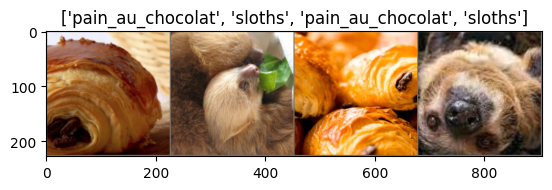

In [9]:
# Get a batch of test data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the grid with a title that concatenates all the class labels
imshow(out, title=[class_names[x] for x in classes])

## Running the model with 25 epochs

We'll now apply a pre-trained model on our data. We won't go over the details of the model, but the code used to create the function `train_model()` is provided below.

### Samples, batches and epochs
- **Sample**: A single instance of data (e.g., one image or one data point).
- **Batch**: A group of samples processed together. The batch size determines how many samples are processed before updating the model's parameters.
- **Epoch**: One complete pass through the entire dataset. During an epoch, the model has the chance to update its parameters after seeing all the data in the dataset once.

### Understanding model, criterion, optimizer and scheduler

1. Model (`model`)
   * **What It Is**: The neural network architecture that you're training. It can be a pre-built model from libraries like torchvision.models (e.g., ResNet, VGG) or a custom model you define using `torch.nn.Module`.
   * **Role**: The model learns to recognize patterns or make predictions based on the input data. During training, the model's parameters (weights and biases) are adjusted to minimize the difference between its predictions and the actual labels.

2. Criterion (`criterion`)
   * **What It Is**: The loss function that measures how well the model's predictions match the true labels. Examples include: 
      * `nn.CrossEntropyLoss`: Used for multi-class classification problems.
      * `nn.MSELoss`: Used for regression tasks.
   * **Role**: The criterion computes the loss value that the optimizer uses to adjust the model's parameters. The goal is to minimize this loss, which means the model's predictions are getting closer to the actual values.

3. Optimizer (`optimizer`)
   * **What It Is**: An algorithm that updates the model's parameters based on the computed gradients. Popular optimizers include:
       * `torch.optim.SGD`: Stochastic Gradient Descent.
       * `torch.optim.Adam`: A more advanced optimizer that adapts the learning rate during training.
   * **Role**: The optimizer uses the gradients from backpropagation to adjust the model's weights, helping the model learn over time. It controls how fast or slow the learning happens (through the learning rate).

4. Scheduler (`scheduler`)
   * **What It Is**: A learning rate scheduler that adjusts the learning rate during training according to a pre-defined schedule. Examples include:
      * `StepLR`: Reduces the learning rate by a factor after a set number of epochs.
      * `ReduceLROnPlateau`: Lowers the learning rate when a metric (e.g., validation loss) stops improving.
   * **Role**: The scheduler helps to fine-tune the learning process. A high learning rate might make training unstable, while a low one can slow it down. By adjusting the learning rate during training, the scheduler can help the model converge faster or avoid getting stuck in local minima.

### Model Training Function 

Rough outline of the `train_model()` method below. Do refer to the comments for a more in-depth explanation: 

1. Initial set-up `
   * Initialise a copy of the model 

2. Looping Through Epochs
   * The function runs for a set number of times, called epochs (default is 25). Each epoch represents one complete pass through the training dataset.

3. Training and Validation Phases
   * Each epoch has two main parts - train and validation (or 'val' as in the code).
   * Training Phase: the model is set to training mode (model.train()), where it can learn and update its internal parameters.
   * Validation Phase: The model is set to evaluation mode (model.eval()), where it runs without updating its parameters to test its learning.

4. Iterating Over Data

5. Gradient and Optimization
   * For each batch, the function clears any previous gradients using `optimizer.zero_grad()`. 
   * It makes predictions `outputs = model(inputs)` and calculates the loss between predictions and actual labels `loss = criterion(outputs, labels)`.
   * If it's the train phase, it calculates gradients with `loss.backward()` and updates the model's weights using `optimizer.step()`.

6. Tracking Performance
   * The function keeps track of the total loss and number of correct predictions for each batch and adds them to running totals.
   * If in the `train` phase, it updates the learning rate using `scheduler.step()`.

7. Calculating and Printing Results

   * At the end of each phase, the function calculates the average loss and accuracy.
   * It prints out the loss and accuracy for both the train and val phases.

8. Saving the Best Model
   * If the accuracy in the val phase is the best seen so far, the function updates best_acc and saves the current model's state.

9. Final Steps

   * The function calculates and prints the total time taken for training.
   * It prints the best accuracy obtained during validation.
   * It loads the best model's weights back into the model and returns it, so the best version is ready to use.


In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Make a deep copy of the model provided
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data using the dataloader we defined
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass, tracking history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Computing loss statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Create a deep copy of the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()  # Print an empty line for nice formatting

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed //
          60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Loading a pre-trained model

We'll use a model called ResNet18, developed by authors [Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun](https://arxiv.org/abs/1512.03385).


Here's what is being done below: 

1. Loading a Pre-trained Model

   * The code loads the ResNet-18 model pre-trained on a large dataset (e.g., ImageNet). This model has already learned general image features, which speeds up training and improves performance for specific tasks.

2. Modifying the Model for Binary Classification:

   * The number of input features to the final fully connected (FC) layer is obtained (num_ftrs).
   * The final FC layer is replaced with a new nn.Linear layer that outputs 2 values, corresponding to the two classes in the binary classification task.

3. Moving the Model to the Appropriate Device:
   * The modified model is moved to the specified device (device), which is typically a GPU or CPU. This ensures the model runs on the hardware that will execute the training or inference.

4. Defining the Loss Function:
   * The code sets the loss function to nn.CrossEntropyLoss(), a common choice for classification tasks. It calculates how well the model’s predictions match the true class labels.

5. Setting Up the Optimizer:
   * The SGD (Stochastic Gradient Descent) optimizer is initialized to adjust the model's parameters during training. It uses a learning rate of 0.001 and a momentum of 0.9 to help accelerate convergence.

6. Defining a Learning Rate Scheduler:
   * A learning rate scheduler (StepLR) is created to decay the learning rate by a factor of 0.1 every 7 epochs. This helps fine-tune the training process by gradually reducing the learning rate, which can improve model stability and performance as training progresses.

In [13]:
# Load the resnet model
model_ft = models.resnet18(pretrained=True)

# Obtaining the number of input features for our final layer
num_ftrs = model_ft.fc.in_features

# Since this is a binary classification task, we'll set the size of each output sample to 2. For multi-class classification, this can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model_ft = model_ft.to(device)

# We'll use CrossEntropyLoss(), which is a common loss function for classification problems
criterion = nn.CrossEntropyLoss()

# In this step, we'll optimize all parameters of the model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# We'll decay learning rate (lr) by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/domszy/Desktop/Sloth or Pastry/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/domszy/Desktop/Sloth or Pastry/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Call our train_model() function with the ResNet model, the criterion, optimizer, learning rate scheduler, and number of epochs that we have defined.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.3539 Acc: 0.8780
val Loss: 0.3720 Acc: 0.7647

Epoch 2/25
----------
train Loss: 0.1476 Acc: 0.9024
val Loss: 0.1607 Acc: 0.9412

Epoch 3/25
----------
train Loss: 0.1213 Acc: 0.9756
val Loss: 0.1666 Acc: 0.9412

Epoch 4/25
----------
train Loss: 0.0480 Acc: 0.9878
val Loss: 0.0796 Acc: 0.9412

Epoch 5/25
----------
train Loss: 0.0439 Acc: 1.0000
val Loss: 0.0972 Acc: 0.9412

Epoch 6/25
----------
train Loss: 0.0498 Acc: 0.9878
val Loss: 0.0894 Acc: 0.9412

Epoch 7/25
----------
train Loss: 0.0358 Acc: 0.9756
val Loss: 0.1179 Acc: 0.9412

Epoch 8/25
----------
train Loss: 0.0530 Acc: 0.9878
val Loss: 0.0877 Acc: 0.9412

Epoch 9/25
----------
train Loss: 0.0331 Acc: 0.9878
val Loss: 0.1036 Acc: 0.9412

Epoch 10/25
----------
train Loss: 0.0255 Acc: 1.0000
val Loss: 0.1056 Acc: 0.9412

Epoch 11/25
----------
train Loss: 0.0534 Acc: 0.9634
val Loss: 0.0874 Acc: 0.9412

Epoch 12/25
----------
train Loss: 0.0191 Acc: 1.0000
val Loss: 0.0884 Acc: 0.9412

E

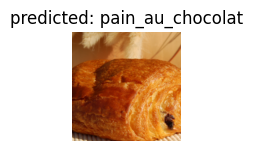

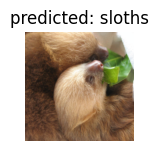

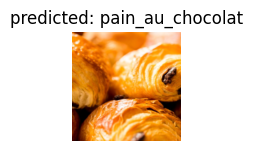

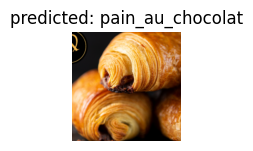

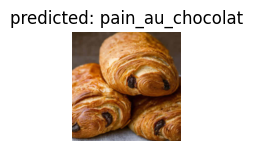

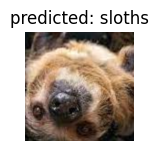

In [17]:
visualize_model(model_ft)

In [18]:
# Disable gradients for model_conv.parameters()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model_conv = model_conv.to(device)

# Set criterion again
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
# Train model_conv
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.4348 Acc: 0.8415
val Loss: 0.5132 Acc: 0.7059

Epoch 2/25
----------
train Loss: 0.2361 Acc: 0.9268
val Loss: 0.2518 Acc: 0.9412

Epoch 3/25
----------
train Loss: 0.1919 Acc: 0.9268
val Loss: 0.5747 Acc: 0.7647

Epoch 4/25
----------
train Loss: 0.1561 Acc: 0.9390
val Loss: 0.3695 Acc: 0.9412

Epoch 5/25
----------
train Loss: 0.1084 Acc: 0.9512
val Loss: 0.1196 Acc: 0.9412

Epoch 6/25
----------
train Loss: 0.0944 Acc: 0.9756
val Loss: 0.2982 Acc: 0.9412

Epoch 7/25
----------
train Loss: 0.0764 Acc: 0.9512
val Loss: 0.1802 Acc: 0.9412

Epoch 8/25
----------
train Loss: 0.1001 Acc: 0.9634
val Loss: 0.2295 Acc: 0.9412

Epoch 9/25
----------
train Loss: 0.0491 Acc: 0.9878
val Loss: 0.2367 Acc: 0.9412

Epoch 10/25
----------
train Loss: 0.0874 Acc: 0.9634
val Loss: 0.2346 Acc: 0.9412

Epoch 11/25
----------
train Loss: 0.0849 Acc: 0.9756
val Loss: 0.2270 Acc: 0.9412

Epoch 12/25
----------
train Loss: 0.0739 Acc: 0.9756
val Loss: 0.2328 Acc: 0.9412

E

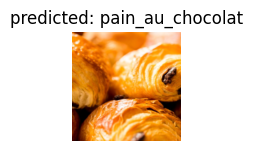

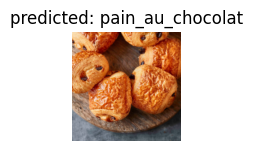

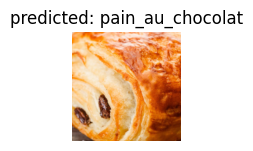

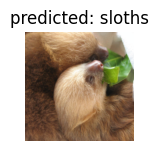

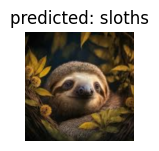

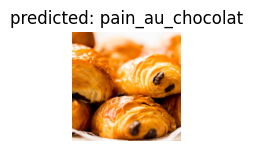

In [21]:
# Visualize model
visualize_model(model_conv)
plt.show()

# References Used

## Tutorials
- [Tutorial] [A beginner's guide to object detection](https://www.datacamp.com/tutorial/object-detection-guide)
- [Course] [Introduction to Deep Learning with PyTorch](https://campus.datacamp.com/courses/introduction-to-deep-learning-with-pytorch/introduction-to-pytorch-a-deep-learning-library?ex=1)
- [Tutorial] [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning)
- [Tutorial] [Writing Custom Datasets, DataLoaders and Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)